# Transaction Classification



## Challenge

For a given set of financial transactions, classify each one into one of seven revenue (transaction) categories. 
 The categories are
- Income
- Private (cash, deposit, donation, presents)
- Living (rent, additional flat expenses, ...)
- Standard of living (food, health, children, ...)
- Finance (credit, bank costs, insurances, savings)
- Traffic (public transport, gas stations, bike, car rent, ...)
- Leisure (hobby, sport, vacation, shopping, ...) 



## Aproach 
A Generic Naive Bayes Classifier is trained and fitted with the trasaction word counts and class category values.

1. Clean and prepare the given data
2. Label the data and store it
3. Define the features you want to use
4. Prepare your features / transform them into a format you can work with
5. Train your model
5. Evaluate your model
6. Visualize your results


In [1]:
#Libraries for Natural LAnguage and Data cleaning 
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\maria\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
# Load necessary libraries for data processing
import numpy as np
import pandas as pd
from matplotlib import cm as colm
import matplotlib.pyplot as plt

# Imports for Classification 
from sklearn.base import clone
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, label_binarize
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_predict, KFold
from sklearn.feature_selection import mutual_info_classif, SelectKBest, f_classif, chi2

#Imports for evaluation metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, auc, roc_curve

## Data

The first step is to load the data in a pandas Dataframe structure 
and have an some information about the dataset.

In [3]:
# Load the data as pandas Dataframe structure
data = pd.read_csv("SAKI Exercise 1 - Transaction Classification - Data Set.csv",sep=';',index_col=0, encoding='utf8',header=0)



#### Data Exploration

In order to obtain a better understanding of data and valuable features, somo basic exploration  and summaries are printed

In [4]:
# Print summary of the column names and Data types 
print(data.info())
#print(' Columns  \t \t \t Data Types\n' + 20*'---'+'\n', data.dtypes)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 209 entries, 0 to 208
Data columns (total 11 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Auftragskonto                      168 non-null    float64
 1   Buchungstag                        209 non-null    object 
 2   Valutadatum                        209 non-null    object 
 3   Buchungstext                       209 non-null    object 
 4   Verwendungszweck                   209 non-null    object 
 5   Beguenstigter/Zahlungspflichtiger  209 non-null    object 
 6   Kontonummer                        208 non-null    object 
 7   BLZ                                208 non-null    object 
 8   Betrag                             209 non-null    object 
 9   Waehrung                           209 non-null    object 
 10  label                              209 non-null    object 
dtypes: float64(1), object(10)
memory usage: 19.6+ KB
None


In [5]:
#Print an first row of the data as overview
data.head()

,Auftragskonto,Buchungstag,Valutadatum,Buchungstext,Verwendungszweck,Beguenstigter/Zahlungspflichtiger,Kontonummer,BLZ,Betrag,Waehrung,label
0,89990201.0,28.07.2016,28.07.2016,Lohn / Gehalt,Gehalt Adorsys GmbH & Co. KG End-To-End-Ref.: ...,Adorsys GmbH & Co. KG,7807800780,25190001,2000.00,EUR,income
1,89990201.0,27.07.2016,27.07.2016,Miete,Byladem1Sbt De12773501123456789889 Miete Beuth...,Georg Tasche,DE31251900019123456780,VOHADE2HXXX,-670.00,EUR,living
2,89990201.0,21.07.2016,21.07.2016,Bargeld,"21.07/16.34Uhr Nuernberg All Eur 70,00 Geb.Eur...",Bargeld,9999900780,25190001,-70.00,EUR,private
3,89990201.0,20.07.2016,20.07.2016,Lebensmittel / Getraenke,2831 Edeka Neubauer Nuernb.//Nuernb 2016-07-20...,Kartenzahlung,9736000780,25190001,-73.21,EUR,standardOfLiving
4,89990201.0,18.07.2016,18.07.2016,Spontanausgabe,Amazon,neue Playstation,9988776655,25125100,-363,EUR,leisure


Explore the Data class frequencies to see if there is a class imbalance

In [6]:
# Print summary of the classes and lablel numbers
print('\nClass Names \t  Class Frequencies\n' + 20*'--')
print(data.label.value_counts())


Class Names 	  Class Frequencies
----------------------------------------
leisure             65
standardOfLiving    47
finance             33
living              26
private             21
income              17
Name: label, dtype: int64


Explore by column how many different entries has each value

In [7]:
print(' Columns  \t \t \t Unique Values \t \t \t Empty Values \n' + 40*'--')
for col in data.columns: 
    print("{0: <35} {1: <35} {2: <35}".format(col, len(data[col].unique()), data[col].isnull().sum()))

 Columns  	 	 	 Unique Values 	 	 	 Empty Values 
--------------------------------------------------------------------------------
Auftragskonto                       3                                   41                                 
Buchungstag                         85                                  0                                  
Valutadatum                         85                                  0                                  
Buchungstext                        14                                  0                                  
Verwendungszweck                    125                                 0                                  
Beguenstigter/Zahlungspflichtiger   59                                  0                                  
Kontonummer                         54                                  1                                  
BLZ                                 41                                  1                                  
Betra

### Clean data

Auxiliary functions to standarize text columns and format. Remove invalid characters in order to standarize and avoid mistakes

In [8]:
from nltk.corpus import stopwords

def remove_punctuation(text: str):
    #Remove punctuation 
    text = text.replace(''' !()-[]{};:'"\,<>./?@#$%^&*_~ ''',' ')
    return text

def replace_german_characters(text: str):
    umlaut_dict = {'ä': 'ae',  'ö': "oe", 'ü': "ue",'Ä': 'Ae',  'Ö': "Oe", 'Ü': "Ue", 'ß': 'ss'}
    text = text.translate(str.maketrans(umlaut_dict))
    return text

def remove_special_characters(df_column: pd.DataFrame): 
    df_column = df_column.astype(str) 
    df_column = df_column.str.lower()
    #df_column = df_column.str.replace('[^a-z-]', ' ') 
    df_column = df_column.apply(lambda text: replace_german_characters(text) )
    #Remove punctuation 
    df_column = df_column.str.replace('[^\w\s]','') #^\w\s (lambda text: remove_punctuation(text))
    #Remove left especial characters
    df_columns =  df_column.str.replace('[^a-zA-Z0-9 \n\. ]', ' ')
    return df_column

def tokenize(df_column: pd.DataFrame, language = 'german'):
    #Stopwords as commented in Q&A session
    remove_words = stopwords.words(language)
    # Remove words as well as two character tokens( assumtion of no  dignificant semantical meaning)
    tokens  = df_column.apply(lambda l: ' '.join([word for word in l.split() if (word not in (remove_words) and len(word) > 2)]))
    return tokens

In [9]:
## Clean and Store the given data casting to proper Data Type

# Remove the invaled values with a numeric(-11111)
data = data.fillna(-1*10000)

#Process Numeric Values
for num_col in data.select_dtypes(include=[np.number]).columns:
    #Replace the comma values as points for conversion
    data[num_col].replace(regex=True, inplace=True, to_replace=',', value='.')
    #Store numeric data as float 
    data[num_col] = data[num_col].astype('float')  
    
#Manually force Betrag to be a float 
data["Betrag"] = data["Betrag"].replace(regex=True, to_replace=',', value='.').astype('float')   

#Preproces object values as Strings
for col in data.select_dtypes(include=["object"]).columns:
    #Remove special and punctuation characters
    data[col] = remove_special_characters(data[col])
    #Remove stopwords and tokenize
    data[col] = tokenize(data[col], language = 'german')

C:\Users\maria\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:19: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\maria\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:21: FutureWarning: The default value of regex will change from True to False in a future version.


In [10]:
# Check taht the transformations are done properly
data.head()

,Auftragskonto,Buchungstag,Valutadatum,Buchungstext,Verwendungszweck,Beguenstigter/Zahlungspflichtiger,Kontonummer,BLZ,Betrag,Waehrung,label
0,89990201.0,28072016,28072016,lohn gehalt,gehalt adorsys gmbh endtoendref notprovided ku...,adorsys gmbh,7807800780,25190001,2000.00,eur,income
1,89990201.0,27072016,27072016,miete,byladem1sbt de12773501123456789889 miete beuth...,georg tasche,de31251900019123456780,vohade2hxxx,-670.00,eur,living
2,89990201.0,21072016,21072016,bargeld,21071634uhr nuernberg all eur 7000 gebeur 000 ...,bargeld,9999900780,25190001,-70.00,eur,private
3,89990201.0,20072016,20072016,lebensmittel getraenke,2831 edeka neubauer nuernbnuernb 20160720t1754...,kartenzahlung,9736000780,25190001,-73.21,eur,standardofliving
4,89990201.0,18072016,18072016,spontanausgabe,amazon,neue playstation,9988776655,25125100,-363.00,eur,leisure


After having an overview of the unique values of tha labels reagrding the columns, only the probably most representative are chosen and the rest are depreciateed as they may lead to an overfitting of the classifier

### Sumarize the data 

In [11]:
from collections import Counter

def plot_token_frequencies(data):
    plt.figure(num=None, figsize=(20, 12), facecolor='w', edgecolor='k')
    text_data = [token for i, text in enumerate(data) for token in text.split()]
    token_counts = Counter(text_data).values()
    tokens = Counter(text_data).keys()
    plt.bar(np.arange(len(tokens)), token_counts, color = 'gray')
    plt.xticks(np.arange(len(tokens)), tokens, rotation="vertical", fontsize=8)


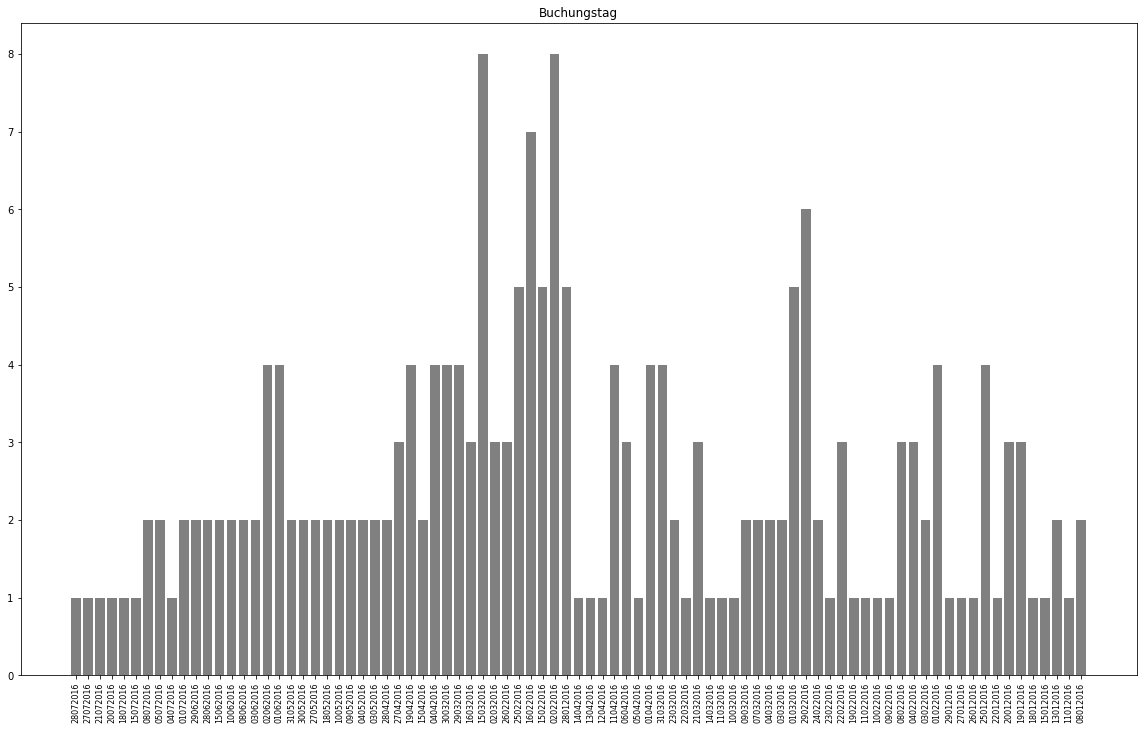

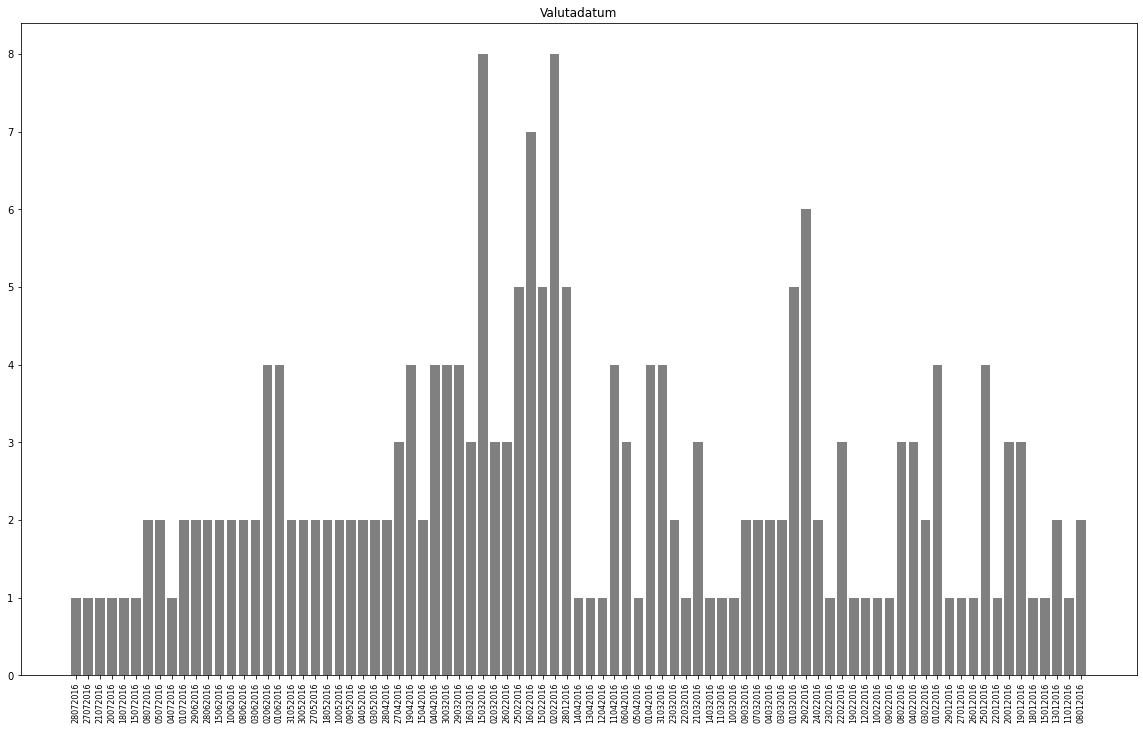

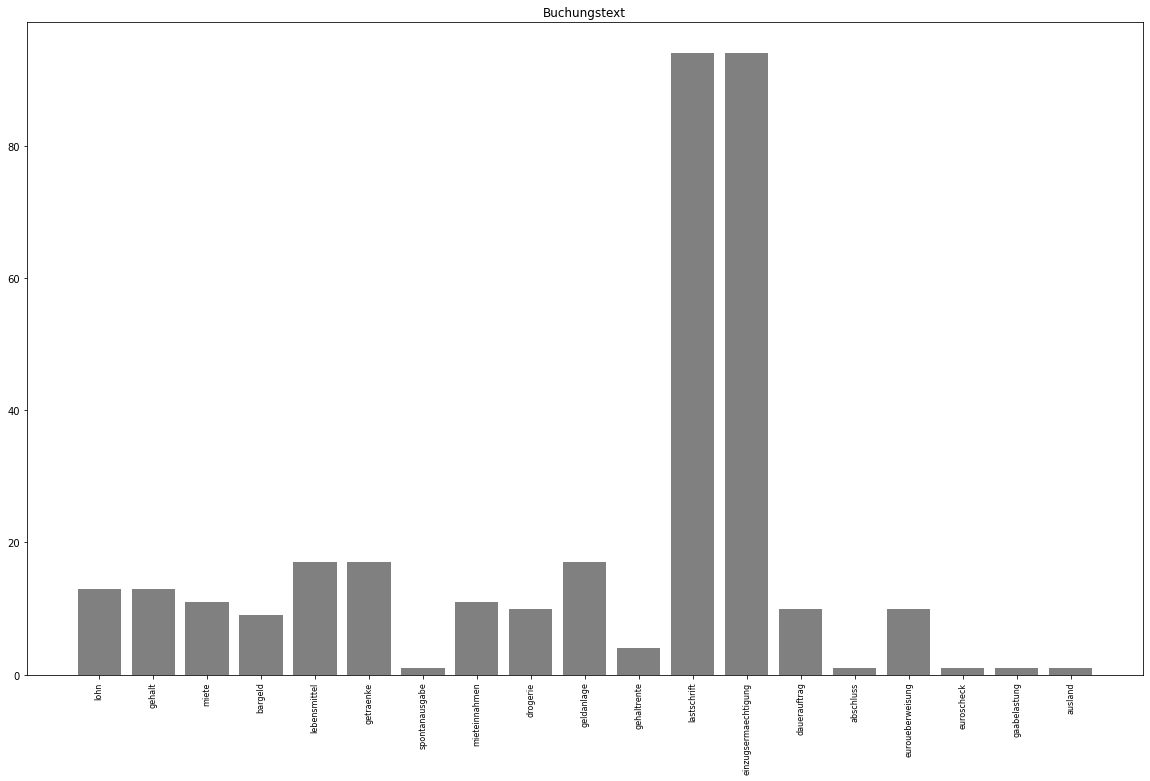

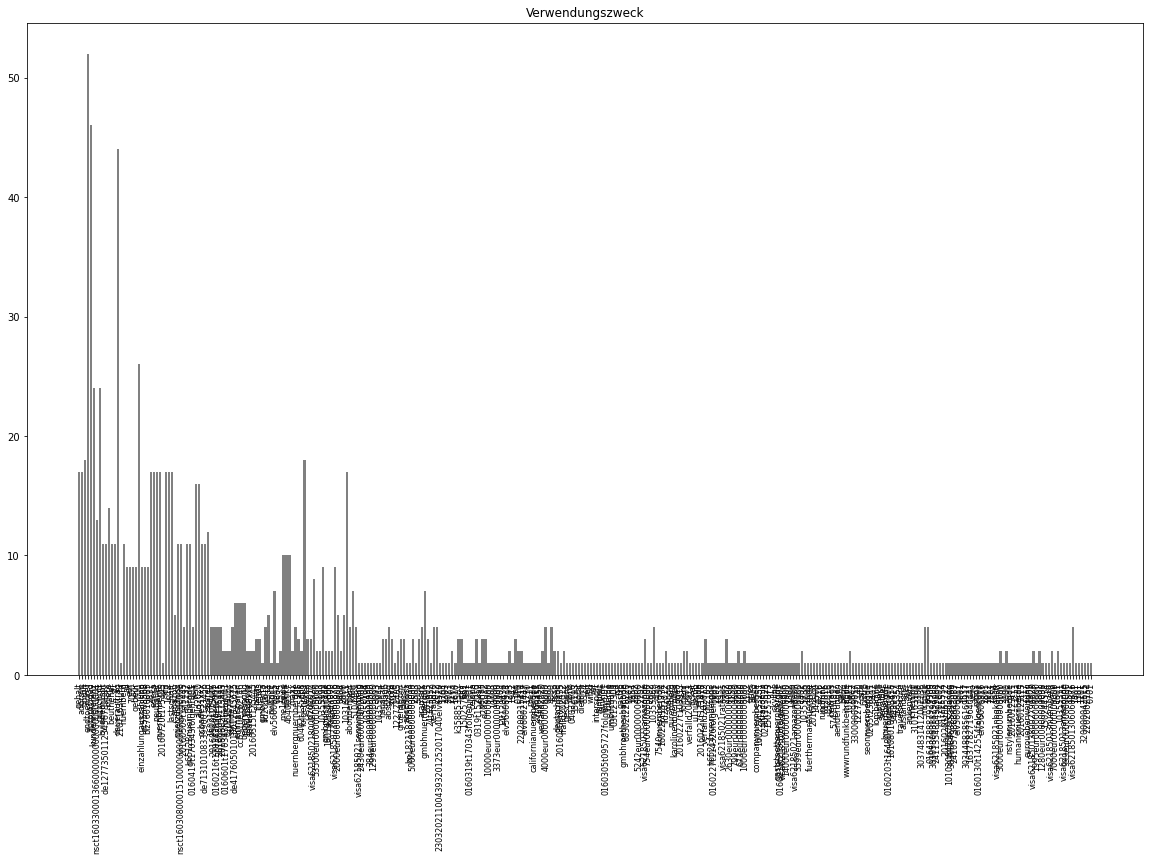

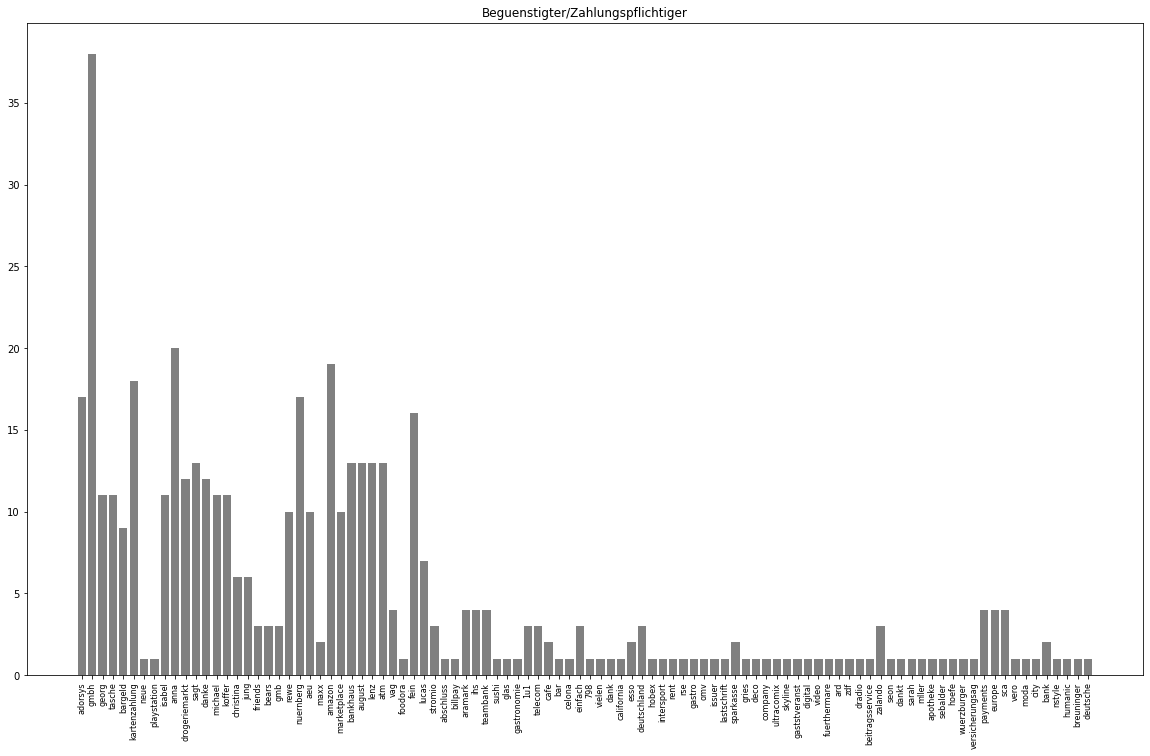

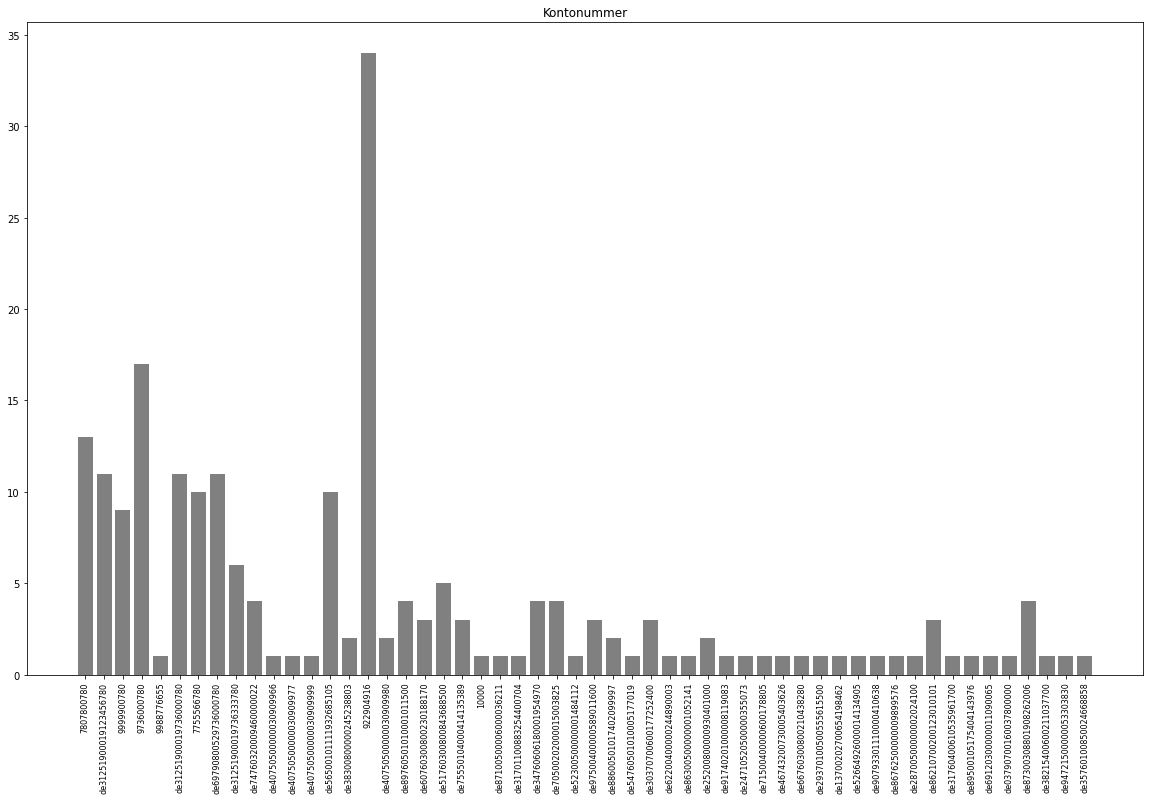

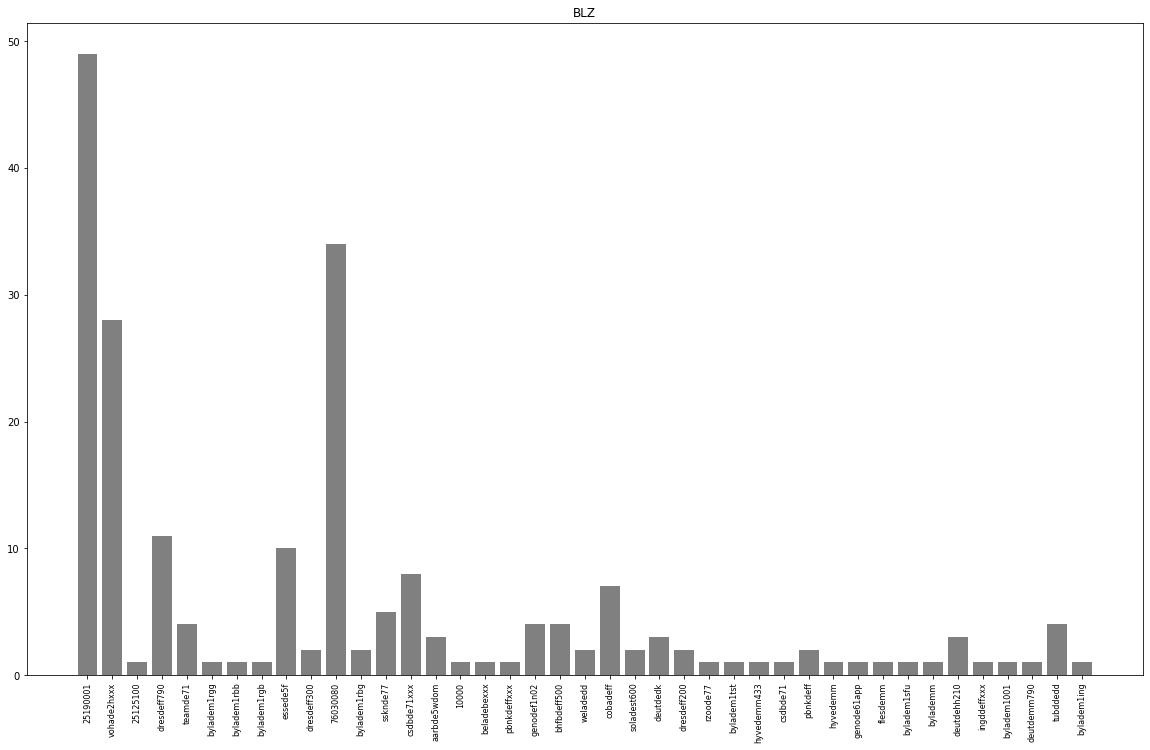

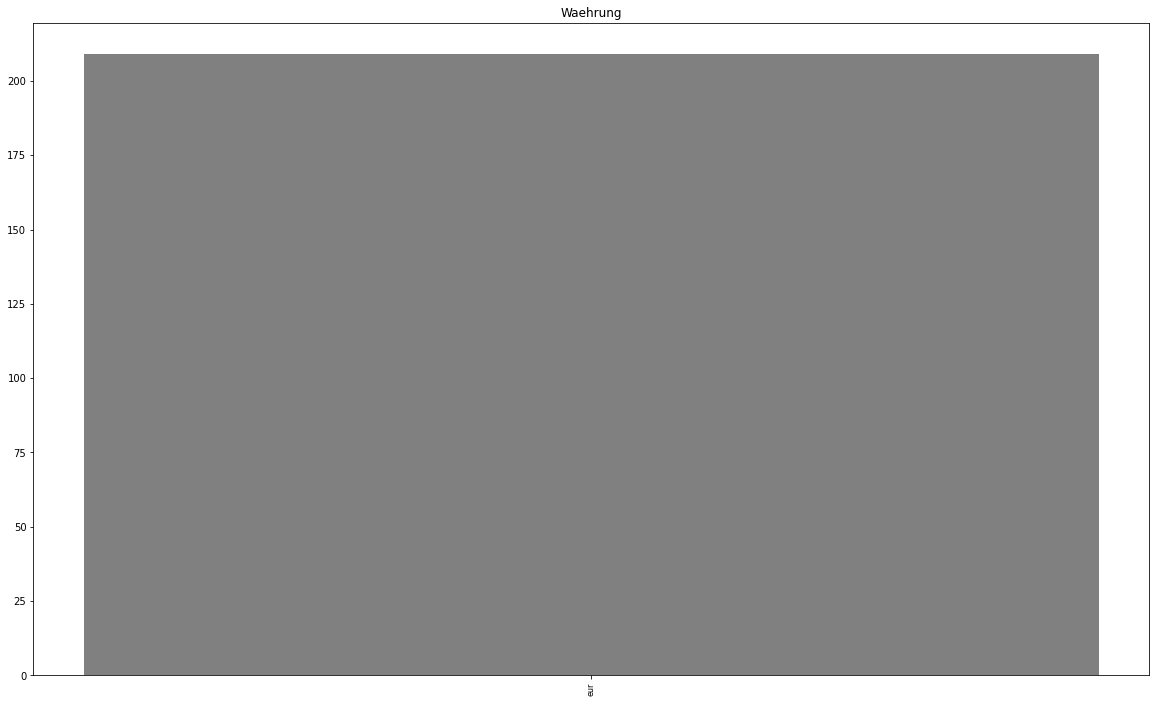

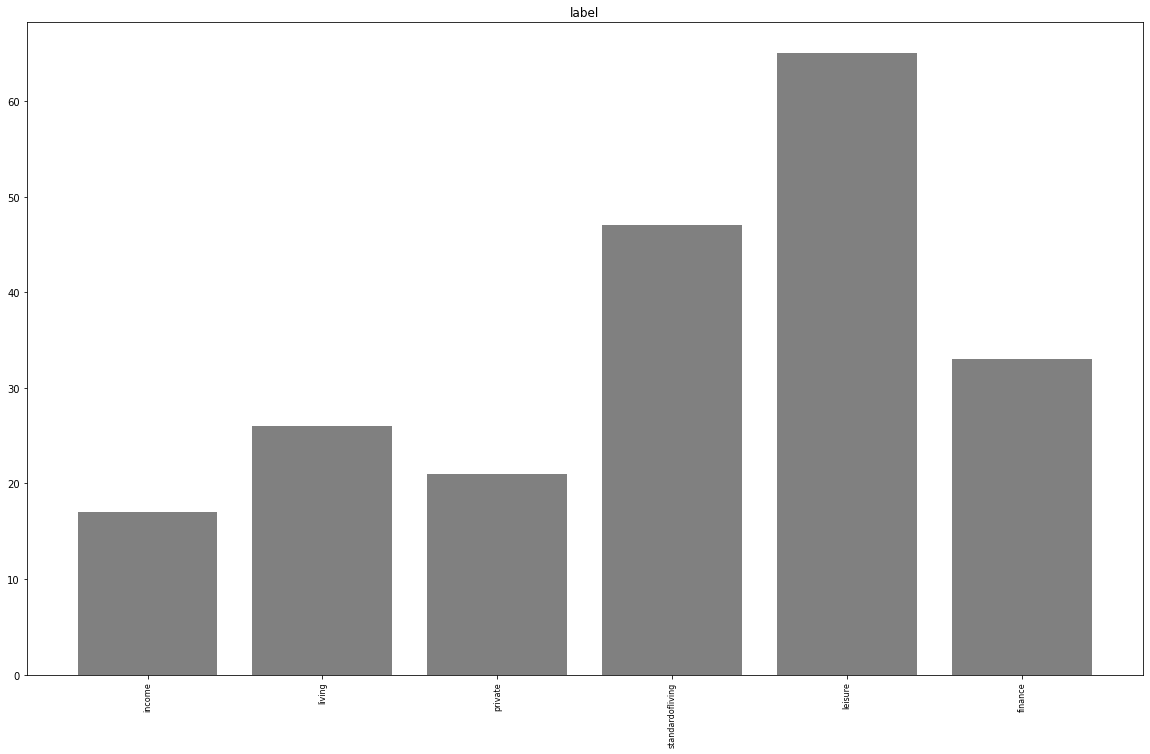

In [12]:
#plot histograms of text tokens
for text_data in data.select_dtypes(include=["object"]):
    plot_token_frequencies(data[text_data])
    plt.title(text_data)

#### Sumarize the data by class

In [13]:
### Get some statistics about the data distribution by class
data.groupby("label").describe(include=[np.number])

Auftragskonto                                          \
                         count          mean           std         min   
label                                                                    
finance                   33.0  5.453558e+07  4.465789e+07    -10000.0   
income                    17.0  5.822543e+07  4.433340e+07    -10000.0   
leisure                   65.0  8.999021e+07  1.116313e+00  89990201.0   
living                    26.0  7.268248e+07  3.617275e+07    -10000.0   
private                   21.0  7.284731e+07  3.621374e+07    -10000.0   
standardofliving          47.0  6.509653e+07  4.069366e+07    -10000.0   

                                                                 Betrag  \
                         25%         50%         75%         max  count   
label                                                                     
finance             -10000.0  89990201.0  89990201.0  89990210.0   33.0   
income              -10000.0  89990201.0  89990201.0  89990210.0   17.0   
leisure           89990210.0  89990210.0  89990210.0  89990210.0   65.0   
living            89990201.0  89990210.0  89990210.0  89990210.0   26.0   
private           89990201.0  89990210.0  89990210.0  89990210.0   21.0   
standardofliving    -10000.0  89990201.0  89990210.0  89990210.0   47.0   

                                                                       \
                         mean         std      min       25%      50%   
label                                                                   
finance           -358.204242  989.732411 -4000.00  -300.000  -250.00   
income            2021.437059  261.455014  1792.73  2000.000  2000.00   
leisure            -54.235538  100.339117  -535.00   -50.000   -24.95   
living            -286.026923  342.676410  -670.00  -670.000   -49.25   
private           -161.389524  234.752327 -1000.00  -110.000  -100.00   
standardofliving  -156.737447  727.777869 -5000.00   -33.595   -25.99   

                                    
                      75%      max  
label                               
finance            200.00   200.00  
income            2000.00  2986.24  
leisure            -17.93     5.00  
living             -32.00   275.98  
private            -50.00   100.00  
standardofliving   -19.99    -5.45

In order to be sure that the selected features  are representative and distributed we plot some descriptive statistics. Safe Check if the data follows a normal distribution, to asses if a a Gaussian Naive Bayes classifier would be best or Multinomial

Text(0.5, 1.0, ' Histogram of the Betrag sorted by class')

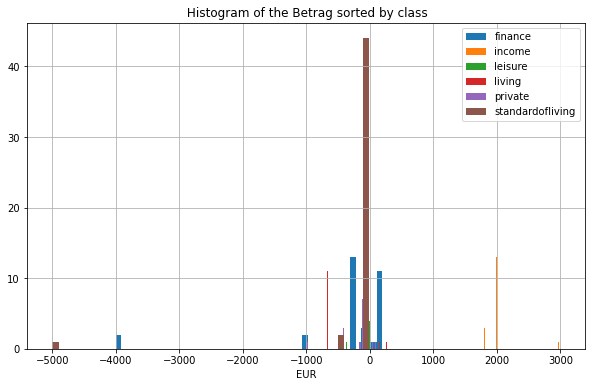

In [14]:
data.groupby("label")["Betrag"].hist(bins=50, figsize=(10,6))
plt.legend(np.unique(data['label']))
plt.xlabel("EUR")
plt.title(" Histogram of the Betrag sorted by class")

## Fearures

###  Define the features

In [15]:
# If wanted select columns that are not necessary to the labels by removing them from the data
non_meaningul_columns = ["Auftragskonto",  "Valutadatum", 'Buchungstag',"Kontonummer", "BLZ", "Waehrung"]
dataset = data.drop(columns=non_meaningul_columns, axis = 1)
# Store the Column Index
features_index = dataset.columns

In [16]:
# Select all the columns as features 
dataset = data.copy() 
dataset.describe(include="object")

,Buchungstag,Valutadatum,Buchungstext,Verwendungszweck,Beguenstigter/Zahlungspflichtiger,Kontonummer,BLZ,Waehrung,label
count,209,209,209,209,209,209,209,209,209
unique,85,85,14,125,59,54,41,1,6
top,02022016,15032016,lastschrift einzugsermaechtigung,gehalt adorsys gmbh endtoendref notprovided ku...,adorsys gmbh,922904916,25190001,eur,leisure
freq,8,8,94,13,17,34,49,209,65


### Prepare features / transform them into a working format

In [17]:
def vectorize_text(text, max_feats=125, transform = False):
    # Convert a collection of text documents to a matrix of token counts
    vectorizer =  CountVectorizer(max_features=max_feats)
    X = vectorizer.fit_transform(text).toarray()
    if transform: # Transform a count matrix to a normalized term-frequency or term-frequency times inverse document-frequency representation
        X = TfidfTransformer().fit_transform(X).toarray()
    return X

def create_feature_matrix(dataset):
    #Process Numeric Values
    X = np.array([]).reshape(-1,1)

    for num_col in dataset.select_dtypes(include=[np.number]).columns:
        #Normalize values to reduce the variance
        X_num = MinMaxScaler(feature_range=(0, 1)).fit_transform(dataset[[num_col]].values)
        X = np.concatenate((X,X_num)).reshape((len(data),-1))

    #Preproces object values as Strings
    for text_col in dataset.select_dtypes(include=["object"]).columns:
        X_text = vectorize_text(dataset[text_col])
        X = np.hstack([X, X_text])

    return X

In [18]:
#Create encoded labels as classes [0-5]
le = LabelEncoder()
y =  le.fit_transform(dataset['label'])
class_labels = dict(zip(le.classes_, le.transform(le.classes_)))
print(class_labels)


{'finance': 0, 'income': 1, 'leisure': 2, 'living': 3, 'private': 4, 'standardofliving': 5}


In [19]:
# Exclude the labels from the features
dataset = dataset.drop(columns=["label"], axis = 1)

In [20]:
# Create a feature matrix by transforming the features 
X = create_feature_matrix(dataset)

### Reduce the features dimensions

In [21]:
# Selection of k best features based on the score
def features_best(X,y,k=50, score = chi2 ):
    selector = SelectKBest(score, k=k)
    X_new = selector.fit_transform(X,y)
    columns = selector.get_support(indices=True)
    return X_new, columns

## Classifier Model

#### Cross Validation

In [22]:
#Cross validation fit and predict auxiliar function
def cross_val_fit_predict(clf, X,y,k_folds=10, shuffle=False, random_state =None ):
    #cv = KFold(n_splits=k_folds, shuffle=shuffle, random_state= random_state)
    cv = StratifiedKFold(n_splits=k_folds, shuffle=shuffle, random_state= random_state)
    y_preds, y_preds_probs,  test_index= [], [], [],

    for i, (train, test) in enumerate( cv.split(X, y)):
        # Store in case of shuffle index
        test_index = np.append(test_index, test)
        
        #Train Classifier Model from scratch
        clf.fit(X[train], y[train])
        
        #Predict labels 
        y_preds = np.append(y_preds, classifier.predict(X[test]))
        
        #Predict probabilities 
        probs = classifier.predict_proba(X[test])
        y_preds_probs = np.append(y_preds_probs, probs).reshape(-1,probs.shape[-1])
        
    return y_preds, y_preds_probs, np.array(test_index, dtype=int)

#### Train the model

In [23]:
#Create Multinomial Naive Bayes classifier 
classifier = MultinomialNB()

In [24]:
# Splite in traing and testing
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10)
y_pred_cv, probs_pred_cv, test_index = cross_val_fit_predict(classifier, X, y, shuffle=True)

## Report Results

#### Evaluation - Confusion matrix

In [25]:
#Create Confusion Matrix
cm_cv = confusion_matrix(y_pred_cv, y[test_index], normalize= None)
cm_cv_norm = confusion_matrix(y_pred_cv, y[test_index], normalize= 'true')
print(cm_cv)

[[29  0  0  0  0  0]
 [ 0 17  0  0  0  0]
 [ 3  0 60  2  0  3]
 [ 0  0  0 21  1  1]
 [ 1  0  2  0 20  3]
 [ 0  0  3  3  0 40]]


#### Evaluation Metrics

In [26]:
# Get accuracy Evaluation Metrics
print(classification_report(y[test_index], y_pred_cv))

              precision    recall  f1-score   support

           0       1.00      0.88      0.94        33
           1       1.00      1.00      1.00        17
           2       0.88      0.92      0.90        65
           3       0.91      0.81      0.86        26
           4       0.77      0.95      0.85        21
           5       0.87      0.85      0.86        47

    accuracy                           0.89       209
   macro avg       0.91      0.90      0.90       209
weighted avg       0.90      0.89      0.90       209



### Visualize results

In [27]:
def plot_multiclass_roc(y_preds, y, labels, figsize=(10, 10)):
    y = label_binarize(y, classes=np.arange(len(labels)))
    y_score = pd.get_dummies(y_preds, drop_first= False).values
    colors = colm.rainbow(np.linspace(0.0, 1.0, len(class_labels)))
    
    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    # Plot a ROC for each class
    fig, ax = plt.subplots(figsize=figsize)
    
    for k,i in labels.items():# range(len(labels)):
        fp,tp,  _ = roc_curve(y[:, i], y_score[:, i])
        fpr[i], tpr[i], _ = roc_curve(y[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        ax.plot( fp,tp,label='Class %s (AUC = %0.2f)' % (k,  auc( fp,tp) ), c =colors[i, :])
    
    ax.set_xlim([-0.02, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.legend(loc="best")

    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver Operating Characteristic')
    
    plt.show()
    

def plot_pobabilities_class( y_prob_cv, test_index, class_labels):
    plt.figure(figsize=(16,12))
    colors = colm.rainbow(np.linspace(0.0, 1.0, len(class_labels)))

    for k,v in list(class_labels.items() ):
        plt.subplot(2,len(class_labels)//2,v+1)
        #order = np.lexsort((probs_class[v], ))
        plt.title(label='Predicted Probability of class {}'.format(k))
        plt.xlabel("Sample ID")
        plt.ylabel("Probability(l={})".format(v))
        plt.bar(test_index, y_prob_cv[:,v],  color = colors[v, :])

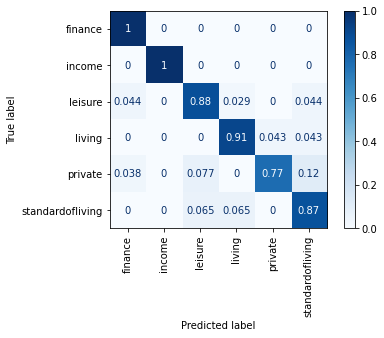

In [28]:
# Display the Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_cv_norm ,display_labels= class_labels.keys())
disp.plot(xticks_rotation= 'vertical', cmap =plt.cm.Blues)

### ROC Curve 

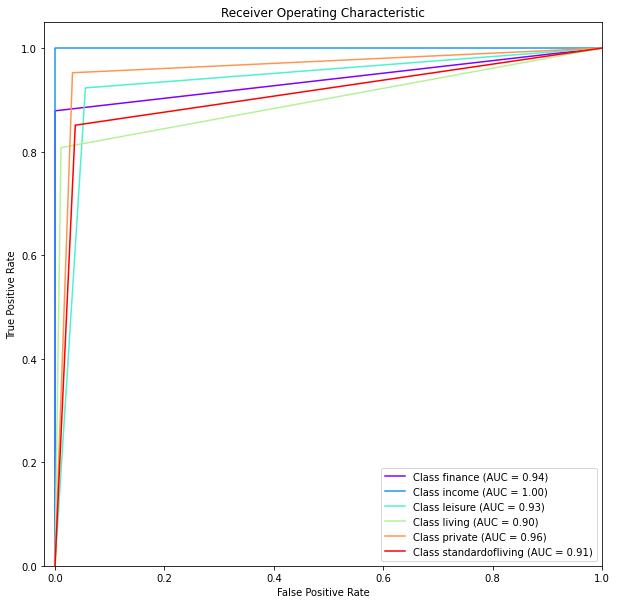

In [29]:
plot_multiclass_roc(y_pred_cv, y[test_index], class_labels)

### Plot probabilities

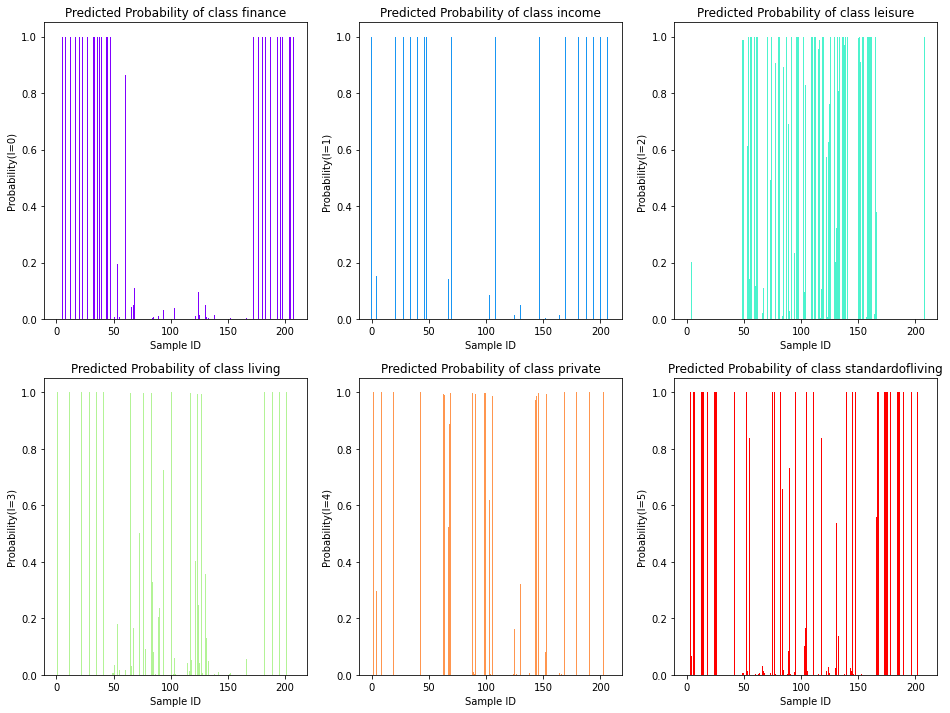

In [30]:
# Get class probabilities for the all sample in the dataset
plot_pobabilities_class( probs_pred_cv, test_index,  class_labels )